<a href="https://colab.research.google.com/github/mchablani/generative_ai/blob/main/colab_notebooks/stable_diffusion/layers_nft_recommendation/zero_shot_image_semantic_similarity_experiments_compare_vit_and_clip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup & Imports
You'll need to log into huggingface and accept the terms of the licence for this model - see the model card for details. And when you first run this notebook you need to uncomment the following two cells to install the requirements and log in to huggingface with an access token.

In [1]:
!pip install faiss-cpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 72.4 MB/s eta 0:00:00


In [2]:
!pip install -q --upgrade transformers diffusers ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
! mkdir "/root/.huggingface"

In [5]:
! cp "drive/MyDrive/.huggingface/token" /root/.huggingface/token

In [6]:
from base64 import b64encode

import numpy
import os
import torch

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
import torch.nn.functional as F
from transformers import logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
torch.cuda.is_available()

True

In [8]:
data_path = '/content/drive/MyDrive/expa/mini_mini_imagenet_data/mini_mini_imagenet'

In [9]:
%ls /content/drive/MyDrive/expa/mini_mini_imagenet_data/


clip_image_index_ids.pkl  mini_mini_imagenet/
clip_image_test_ids.pkl   nfts_flatten_vit.index
image_index_clip.index    vit_image_index_ids.pkl
image_index_ids.pkl       vit_image_test_ids.pkl
image_index.index         vit_nfts_flatten_index_ids.pkl
image_index_vit.index     vit_nfts_flatten_test_ids.pkl
image_test_ids.pkl


In [10]:
import numpy as np
import faiss
import pickle

# CLIP image encoder

In [11]:
print("Downloading CLIP and installing requirements")
!git clone https://github.com/openai/CLIP                 &> /dev/null
!pip install -q  ftfy==6.1.1 regex==2022.4.24 tqdm==4.64.0 omegaconf==2.2.1 pytorch-lightning==1.6.3 &> /dev/null

from CLIP import clip # The clip model
import torch.nn.functional as F # Some extra methods we might need
from tqdm.notebook import tqdm # A progress bar library

In [12]:
# Load in one of the models from CLIP
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
clip_model, clip_preprocess = clip.load('ViT-B/32', device=device)
perceptor = clip_model.requires_grad_(False)
# perceptor = clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device)
print(perceptor.visual.input_resolution) # 224px a side

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 132MiB/s]


224


In [ ]:
?? clip_preprocess

In [13]:
def encode_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = clip_preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        encoded_image = clip_model.encode_image(image_tensor)

    return encoded_image

In [14]:
# test code
!curl --output cat.jpeg "https://images.pexels.com/photos/156934/pexels-photo-156934.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1" > /dev/null
!curl --output fire.jpeg "https://images.pexels.com/photos/207353/pexels-photo-207353.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1" > /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58417  100 58417    0     0  1097k      0 --:--:-- --:--:-- --:--:-- 1097k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 52516  100 52516    0     0   244k      0 --:--:-- --:--:-- --:--:--  244k


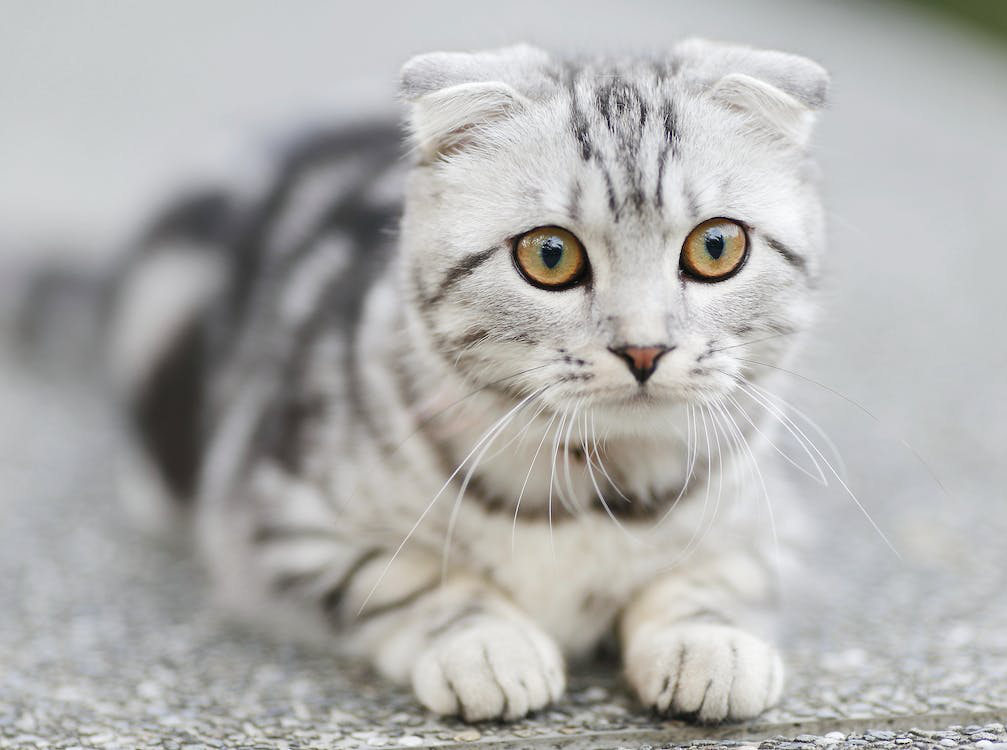

In [ ]:
test_image_path = 'cat.jpeg' #@param
test_image = Image.open(test_image_path).convert("RGB")
test_image.show()
# test_image_tensor = pil_to_torch()

In [ ]:
encoded_test_image = encode_image(test_image_path)

In [ ]:
encoded_test_image.shape

torch.Size([1, 512])

In [14]:
index = faiss.IndexFlatL2(512)

In [15]:
id_index = faiss.IndexIDMap(index)

In [16]:
test_ids, index_ids = {}, {}

In [17]:
def get_recommendations(id):
  test_img = test_ids[id]
  print("Test image : ", test_img)
  file_path = os.path.join(data_path, str(test_img))
  img = Image.open(file_path).resize((224, 224))
  img.show()
  encoded_input = encode_image(file_path).cpu()
  k = 30
  distances, indices = id_index.search(encoded_input, k)
  for i in range(5):
    match_img = index_ids[indices[0][i]]
    print("Match ", i, " : ", match_img)
    img = Image.open(os.path.join(data_path, match_img)).resize((224, 224))
    img.show()

In [71]:
with tqdm(total=len(os.listdir(data_path))) as pbar:
  id = 0
  with torch.no_grad():
    for file_name in os.listdir(data_path):
        file_path = os.path.join(data_path, file_name)
        pbar.update(1)
        try:
          # print(file_path)
          encoded = encode_image(file_path)
          # print(encoded.shape)
          if id % 10 == 0:
            test_ids[id] = file_name
          else:
            index_ids[id] = file_name
            id_index.add_with_ids(encoded.cpu(), np.array(id))
          id += 1
          # if id > 100:
          #   break
        except IOError:
            print(f"Error opening file: {file_path}")
            continue

In [45]:
# faiss.write_index(id_index, '/content/drive/MyDrive/expa/mini_mini_imagenet_data/image_index_clip.index')
# with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/clip_image_index_ids.pkl', 'wb') as f:
#   pickle.dump(index_ids, f)
# with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/clip_image_test_ids.pkl', 'wb') as f:
#   pickle.dump(test_ids, f)

In [21]:
id_index = faiss.read_index('/content/drive/MyDrive/expa/mini_mini_imagenet_data/image_index_clip.index')
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/clip_image_test_ids.pkl', 'rb') as f:
  test_ids = pickle.load(f)
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/clip_image_index_ids.pkl', 'rb') as f:
  index_ids = pickle.load(f)

In [22]:
len(test_ids)

990

Test image :  n02110063_12817.JPEG


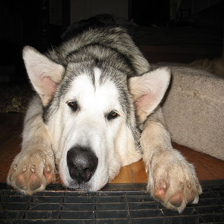

Match  0  :  n02108551_2434.JPEG


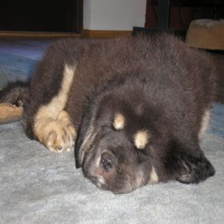

Match  1  :  n02110063_8825.JPEG


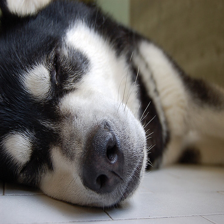

Match  2  :  n02110063_13343.JPEG


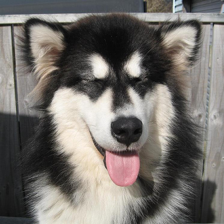

Match  3  :  n02110063_10680.JPEG


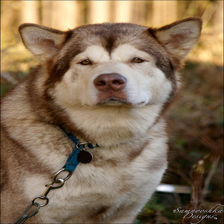

Match  4  :  n02110063_13955.JPEG


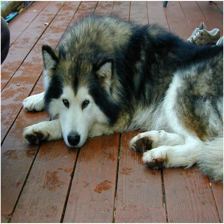

In [72]:
get_recommendations(800)

Test image :  n07697537_12318.JPEG


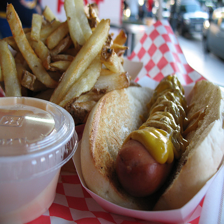

Match  0  :  n07697537_35600.JPEG


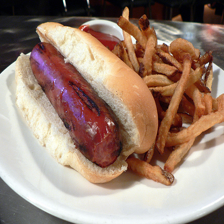

Match  1  :  n07697537_24811.JPEG


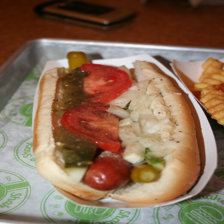

Match  2  :  n07697537_15183.JPEG


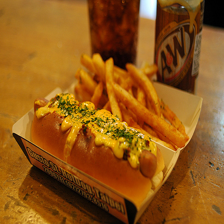

Match  3  :  n07697537_20918.JPEG


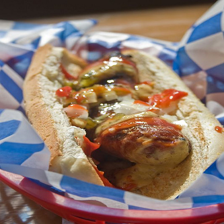

Match  4  :  n07697537_38077.JPEG


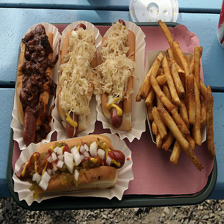

In [73]:
get_recommendations(8020)

Test image :  n03075370_12767.JPEG


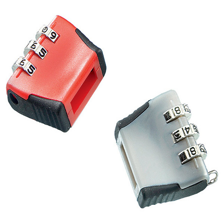

Match  0  :  n03075370_2116.JPEG


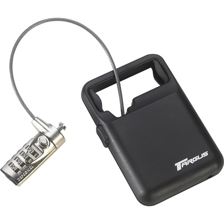

Match  1  :  n03075370_2935.JPEG


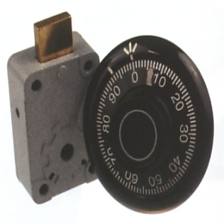

Match  2  :  n03075370_1442.JPEG


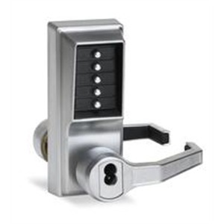

Match  3  :  n03062245_2936.JPEG


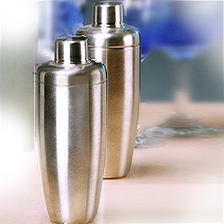

Match  4  :  n03075370_2033.JPEG


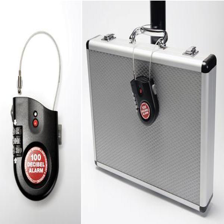

In [74]:
get_recommendations(3800)

Test image :  n04596742_5213.JPEG


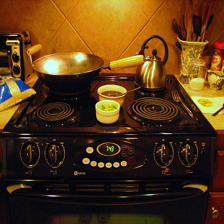

Match  0  :  n04596742_22988.JPEG


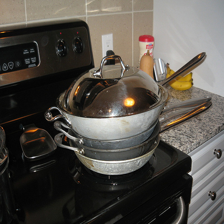

Match  1  :  n04596742_20782.JPEG


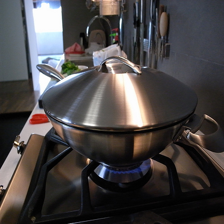

Match  2  :  n03775546_1538.JPEG


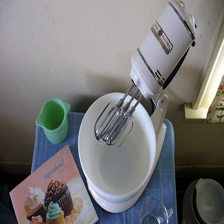

Match  3  :  n03400231_12705.JPEG


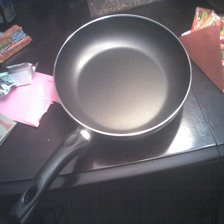

Match  4  :  n04596742_2627.JPEG


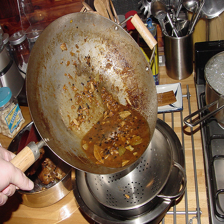

In [75]:
get_recommendations(1800)

# FB Dino ViT image encoder

In [23]:
# Load the pre-trained ViT model
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')

# Define preprocessing pipeline for images
transform = tfms.Compose([
    tfms.Resize(256),
    tfms.CenterCrop(224),
    tfms.ToTensor(),
    tfms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 164MB/s]


The Autoencoder (AE)
The AE can 'encode' an image into some sort of latent representation, and decode this back into an image. I've wrapped the code for this into a couple of functions here so we can see what this looks like in action:

Generate index

In [61]:
index = faiss.IndexFlatL2(384)

In [62]:
id_index = faiss.IndexIDMap(index)

In [63]:
test_ids, index_ids = {}, {}

In [64]:
def get_recommendations_dino(id):
  with torch.no_grad():
    test_img = test_ids[id]
    print("Test image : ", test_img)
    file_path = os.path.join(data_path, str(test_img))
    img = Image.open(file_path).resize((224, 224))
    img.show()
    encoded_input = model(transform(img).unsqueeze(0)).squeeze().reshape(1, -1).cpu()
    k = 30
    distances, indices = id_index.search(encoded_input, k)
    for i in range(5):
      match_img = index_ids[indices[0][i]]
      print("Match ", i, " : ", match_img)
      img = Image.open(os.path.join(data_path, match_img)).resize((224, 224))
      img.show()

In [65]:
id = 0
with tqdm(total=len(os.listdir(data_path))) as pbar:
  with torch.no_grad():
    for file_name in os.listdir(data_path):
      file_path = os.path.join(data_path, file_name)
      pbar.update(1)
      try:
          # Open the image file with PIL
          # print(file_path)
          img = Image.open(file_path).convert("RGB")
          # print(img.format)
          # img.show()
          if id % 10 == 0:
            test_ids[id] = file_name
          else:
            index_ids[id] = file_name
            img = transform(img).unsqueeze(0)
            encoded = model(img).squeeze().reshape(1, -1)
            # print(encoded.shape)
            id_index.add_with_ids(encoded.cpu(), np.array(id))
          # if id > 100:
          #   break
          id += 1
      except IOError:
          print(f"Error opening file: {file_path}")
          continue

  0%|          | 0/9898 [00:00<?, ?it/s]

In [66]:
faiss.write_index(id_index, '/content/drive/MyDrive/expa/mini_mini_imagenet_data/image_index_vit.index')
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/vit_image_test_ids.pkl', 'wb') as f:
  pickle.dump(test_ids, f)
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/vit_image_index_ids.pkl', 'wb') as f:
  pickle.dump(index_ids, f)

In [67]:
id_index = faiss.read_index('/content/drive/MyDrive/expa/mini_mini_imagenet_data/image_index_vit.index')


In [68]:
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/vit_image_test_ids.pkl', 'rb') as f:
  test_ids = pickle.load(f)

In [69]:
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/vit_image_index_ids.pkl', 'rb') as f:
  index_ids = pickle.load(f)

In [70]:
len(test_ids)

990

In [71]:
len(index_ids)

8908

In [72]:
# test_ids

Test image :  n02110063_12817.JPEG


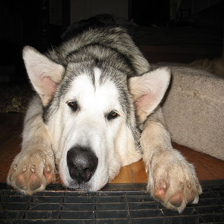

Match  0  :  n02110063_10382.JPEG


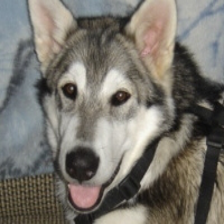

Match  1  :  n02110063_431.JPEG


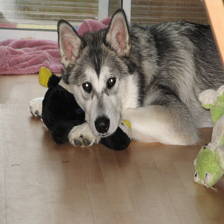

Match  2  :  n02110063_2593.JPEG


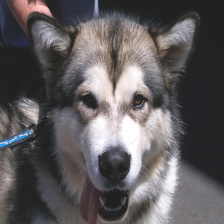

Match  3  :  n02110063_16159.JPEG


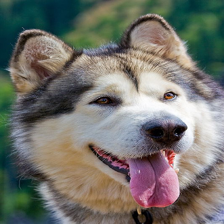

Match  4  :  n02110063_9052.JPEG


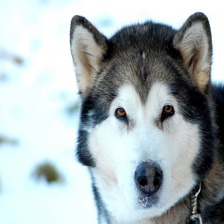

In [73]:
get_recommendations_dino(800)

Test image :  n07697537_12318.JPEG


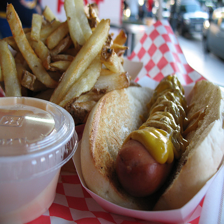

Match  0  :  n07697537_20676.JPEG


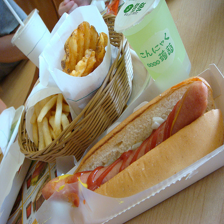

Match  1  :  n07697537_14236.JPEG


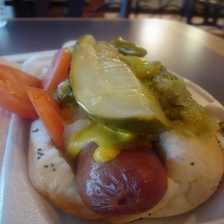

Match  2  :  n07697537_35600.JPEG


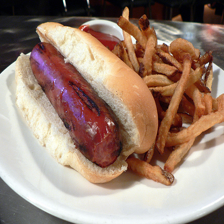

Match  3  :  n07697537_28096.JPEG


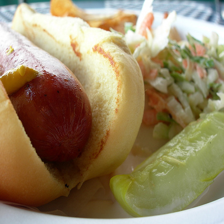

Match  4  :  n07697537_12496.JPEG


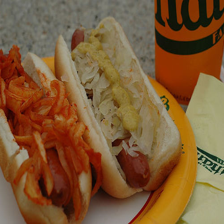

In [74]:
get_recommendations_dino(8020)

Test image :  n03075370_12767.JPEG


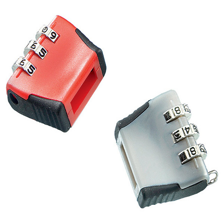

Match  0  :  n03075370_2116.JPEG


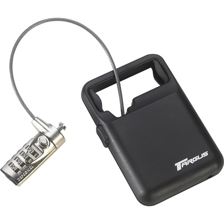

Match  1  :  n03075370_16283.JPEG


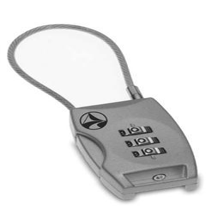

Match  2  :  n03075370_10221.JPEG


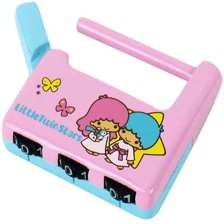

Match  3  :  n04067472_13570.JPEG


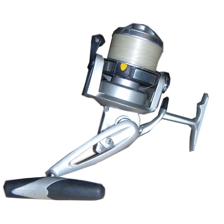

Match  4  :  n03075370_4801.JPEG


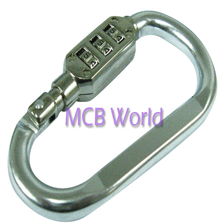

In [75]:
get_recommendations_dino(3800)

Test image :  n04596742_5213.JPEG


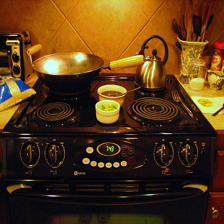

Match  0  :  n03400231_14174.JPEG


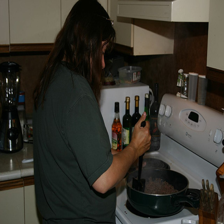

Match  1  :  n03584254_3582.JPEG


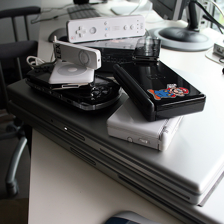

Match  2  :  n04522168_25024.JPEG


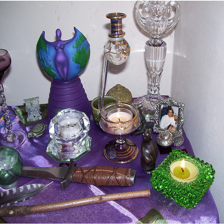

Match  3  :  n03400231_39147.JPEG


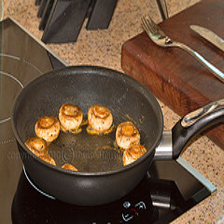

Match  4  :  n04596742_7187.JPEG


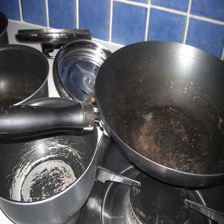

In [76]:
get_recommendations_dino(1800)